In [1]:
import os
import sys
import random
import copy
import pickle
from argparse import ArgumentParser

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.nn.functional as F
import torcheval.metrics.functional as mF
from timm.scheduler import CosineLRScheduler

sys.path.append('./libs')
from load_data import *
from utils import *
from utils_processing import *

/home/vscode/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
weak_cols_dict = {
    'adult': ['fnlwgt', 'capital-loss', 'capital-gain', 'education-num'],
    'default': ['BILL_AMT6', 'BILL_AMT5', 'AGE', 'PAY_AMT6', 'PAY_AMT5', 'PAY_6', 'PAY_5'],
    'diabetes': ['num_lab_procedures', 'num_procedures', 'num_medications', 'time_in_hospital', 'number_outpatient', 'number_emergency'],
    'jets': ['d2_a1_b1_mmdt', 'd2_b1_mmdt', 'c1_b0_mmdt', 'm2_b2_mmdt', 'd2_b2_mmdt', 'm2_b1_mmdt', 'n2_b2_mmdt', 'n2_b1_mmdt', 'd2_a1_b2_mmdt', 'zlogz'],
    'electricity': ['day', 'vicprice', 'transfer', 'period', 'vicdemand'],
    'mv': ['x9', 'x10', 'x2', 'x1', 'x5', 'x4'],
    'run-or-walk': ['gyro_z', 'gyro_y', 'acceleration_x', 'acceleration_z']
}

weak_cols_dict_all = {
    'default': ['all'],
    'jannis': ['all'],
    'jets': ['all'],
    'run-or-walk': ['all'],
    'higgs': ['all'],
    'numerai': ['all'],
    'electricity': ['all'],
    'mv': ['all'],
   
}

num_classes_dict = {
    'adult': {'target': 2,},
    'default': {'target': 2,},
    'diabetes': {'target': 3,},
    'jets': {'target': 5},
    'jannis': {'target': 2},
    'run-or-walk': {'target': 2},
    'higgs': {'target': 2},
    'numerai': {'target': 2},
    'electricity': {'target': 2},
    'mv': {'target': 2},
}

num_features_dict = {
    'adult': 14,
    'default': 23,
    'diabetes': 32,
    'jets': 17,
    'jannis': 55,
    'run-or-walk': 7,
    'higgs': 29,
    'numerai':22,
    'electricity': 8,
    'mv': 11,
}

lipschitz_dict = {
    'logistic': 1,
}


dataset_show_dict = {
    'adult': 'Adult',
    'default': 'Default',
    'diabetes': 'Diabetes',
    'jets': 'Jets',
    'jannis': 'Jannis',
    'run-or-walk': 'Run-or-Walk',
    'higgs': 'Higgs',
    'numerai': 'Numerai',
    'electricity': 'Electricity',
    'mv': 'Mv',
}

args_dict_base = {
    'output_dir': '../../output',
    'sample_size': -1,
    'test_rate':0.5,
    'pred_arch': 'mlp',
    'pred_loss': 'logistic',
    'hd': 500,
    'lr': 0.00005,
    'bs': 512,
    'ep': 100,
    'wd': 0.0002,
    'weaken_mode': 'missing',
    'sm_k': 10,
    'sm_prop_latent': 0.5,
}

## Implement Bound

In [3]:
def risk_bound_f_fixed_g_continuous_partial(
    sample_size:int,
    delta:float,
    M_l:float, # U_l
    weak_col_list:list,
    est_model_mse_pred_risks:list,
    L_l: float, # Lipschits coefficient of loss function
    num_classes: int,
    best_risk:float, # R_l(f_F)
    true_likelihood:float,
    # for Rademacher compelxity of two-layer perceptron
    input_dim:int,
    input_norm:float, # max of square L2 norm of instances
    layer_norm:float, 
    ):

    weak_feat_num = len(weak_col_list)

    rademacher_bound = L_l * np.sqrt( (layer_norm**2 * np.min([2, 4 * np.log(2*input_dim)]) * input_norm  ) / sample_size )
    if num_classes > 2: # multiclass
        rademacher_bound = num_classes**2 * rademacher_bound 
    
    delta_term = M_l * np.sqrt( np.log(2/delta) / (2*sample_size) )

    bound = 4 * ( 2* rademacher_bound + delta_term)
    bound += 2 * np.sqrt( 2 * np.pi * M_l
                            * (  np.sum(est_model_mse_pred_risks)  )
                            * (best_risk + 4* rademacher_bound + delta_term  + 2* M_l * np.sqrt(  np.pi * np.sum(est_model_mse_pred_risks) / 2.0 ) ) ) 
    bound += best_risk


    return bound

In [4]:
# bound test
args = pseudo_args(args_dict_base)

args.exp_name = 'continuous_exp1'
args.dataset_name = 'adult'
args.weak_cols = weak_cols_dict[args.dataset_name]
args.miss_pattern = 'MCAR'
args.miss_rate = 0.5

args.est_error_mse = 0.001
args.rm_k = 2

args.seed = 42
args.use_train_size = 10000

log_name = get_log_filename(args)
with open(os.path.join(args.output_dir, f"{args.exp_name}_{args.dataset_name}", log_name, log_name + '_log.pkl'), 'rb') as f:
    log = pickle.load(f)



delta = 0.01
layer_norm = 1.0

est_model_mse_pred_risks = []
for weak_col in args.weak_cols:
    est_test_acc = log['est_model_test_scores'][weak_col]['mse']
    est_model_mse_pred_risks.append(1.0 - est_test_acc)
pred_model = log['pred_model (est)'] 



bound = risk_bound_f_fixed_g_continuous_partial(
            sample_size = args.use_train_size,
            delta = delta,
            M_l = 1.0,
            weak_col_list = args.weak_cols,
            est_model_mse_pred_risks= est_model_mse_pred_risks,
            L_l = lipschitz_dict[args.pred_loss],
            num_classes = pred_model.fc_final.out_features,
            best_risk=0.0,
            true_likelihood=0.0,
            input_dim= pred_model.fc1.in_features,
            input_norm= pred_model.fc1.in_features, 
            layer_norm=layer_norm,
        )
bound

24.976362109111868

In [5]:
def load_exp1_data(args, seed_list, use_train_size_list, est_error_mse_list, delta, M_l, lipschitz_dict, best_risk, num_features_dict, layer_norm):
    risk_seq_dict = {}
    bound_seq_dict = {}

    for est_error_mse in est_error_mse_list:
        risk_seq = []
        bound_seq = []
        for use_train_size in use_train_size_list:
            risk_tmp_seq = []
            bound_tmp_seq = []
            
            for seed in seed_list:
                args.est_error_mse = est_error_mse
                args.use_train_size = use_train_size
                args.seed = seed
                
                log_name = get_log_filename(args)
                with open(os.path.join(args.output_dir, f"{args.exp_name}_{args.dataset_name}", log_name, log_name + '_log.pkl'), 'rb') as f:
                    log = pickle.load(f)

                est_model_mse_pred_risks = [est_error_mse]*len(args.weak_cols)
                pred_model = log['pred_model (est)'] 


                bound = risk_bound_f_fixed_g_continuous_partial(
                                sample_size = args.use_train_size,
                                delta = delta,
                                M_l = M_l,
                                weak_col_list = args.weak_cols,
                                est_model_mse_pred_risks= est_model_mse_pred_risks,
                                L_l = lipschitz_dict[args.pred_loss],
                                num_classes = pred_model.fc_final.out_features,
                                best_risk=0.0,
                                true_likelihood=0.0,
                                input_dim= pred_model.fc1.in_features,
                                input_norm= pred_model.fc1.in_features, 
                                layer_norm=layer_norm,
                            )
                
                risk_tmp_seq.append(log['pred_model_test_score (est)']['loss'])
                bound_tmp_seq.append(bound)
            
            risk_seq.append(np.mean(risk_tmp_seq))
            bound_seq.append(np.mean(bound_tmp_seq))
        
        risk_seq_dict[est_error_mse] = risk_seq
        bound_seq_dict[est_error_mse] = bound_seq

    return risk_seq_dict, bound_seq_dict

In [6]:
def plot_exp1_base(args, seed_list, use_train_size_list, 
                   est_error_mse_list,
                   delta=0.001, layer_norm=1, M_l=1.0, best_risk=0.0, true_likelihood=0.0,
                   show_fig=True, figsize_base=(3.5,3.5), fontsize=13, show_ylabel=True,
                   risk_ax=None, bound_ax=None, return_ax=False):

    plt.rcParams["font.family"] = "DejaVu Serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['text.usetex'] = True
    plt.rc('text.latex', preamble=r'\usepackage{bm}')

    # load data
    risk_seq_dict, bound_seq_dict = load_exp1_data(args=args, 
                                                   seed_list=seed_list, use_train_size_list=use_train_size_list, est_error_mse_list=est_error_mse_list, 
                                                   delta=delta, M_l=M_l, lipschitz_dict=lipschitz_dict, best_risk=best_risk, num_features_dict=num_features_dict, layer_norm=layer_norm)


    # plot
    fig = plt.figure(figsize=(figsize_base[0], figsize_base[1]*2), tight_layout=True)
    if bound_ax is None:
        bound_ax = fig.add_subplot(2,1,1)
    if risk_ax is None:
        risk_ax = fig.add_subplot(2,1,2)


    cm = plt.get_cmap('viridis')
    markers = ['o', '^', ]
    # plot
    for plot_idx, est_error_mse in enumerate(est_error_mse_list):
        risk_ax.plot(use_train_size_list, risk_seq_dict[est_error_mse], label=r'$R_{\mathrm{MSE}, j}(g_j)=$'+str(est_error_mse) +' ' +r'$\forall j \in [F^{\mathrm{w}}]$',
                     marker='o', linestyle='-', markeredgecolor='black', color=cm( (plot_idx) /len(est_error_mse_list)  ))
        bound_ax.plot(use_train_size_list, bound_seq_dict[est_error_mse], label=r'$R_{\mathrm{MSE}, j}(g_j)=$'+str(est_error_mse) +' ' +r'$\forall j \in [F^{\mathrm{w}}]$',
                        marker='o', linestyle='--', markeredgecolor='black', color=cm( (plot_idx) /len(est_error_mse_list) ))
    
    risk_ax.set_xlabel(r'$n$', fontsize=fontsize)
    bound_ax.set_xlabel(r'$n$', fontsize=fontsize)
    if show_ylabel:
        risk_ax.set_ylabel(r'$R_{\bm{g}, l}(f_{\bm{g}, \bar{S}})$', fontsize=fontsize)
        bound_ax.set_ylabel('Bound', fontsize=fontsize)

    risk_ax.set_xticks(use_train_size_list[::2])
    bound_ax.set_xticks(use_train_size_list[::2])


    risk_ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    risk_ax.yaxis.offsetText.set_fontsize(fontsize)
    risk_ax.xaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    risk_ax.xaxis.offsetText.set_fontsize(fontsize)

    bound_ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    bound_ax.yaxis.offsetText.set_fontsize(fontsize)
    bound_ax.xaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    bound_ax.xaxis.offsetText.set_fontsize(fontsize)

    risk_ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    bound_ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    risk_ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    bound_ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))


    risk_ax.tick_params(labelsize=fontsize)
    bound_ax.tick_params(labelsize=fontsize)

    risk_ax.legend(fontsize=fontsize)
    bound_ax.legend(fontsize=fontsize)
    
    risk_ax.grid()
    bound_ax.grid()
    
    
    if show_fig:
        plt.plot()

    if return_ax:
        plt.close()
        return risk_ax, bound_ax


In [7]:
def plot_exp1_multi_data(args, weak_cols_dict, 
                         dataset_list, seed_list, use_train_size_list, 
                         est_error_mse_list,
                         delta=0.001, layer_norm=1, M_l=1.0, best_risk=0.0, true_likelihood=0.0,
                         each_ax_size=(3,3),
                         show_fig=True,
                         save_name=None):
    
    ncol = len(dataset_list)
    nrow = 2
    wide_size = each_ax_size[0]
    height_size = each_ax_size[1]
    fig = plt.figure(figsize=(wide_size*ncol, height_size*nrow), tight_layout=True)

    for col_idx, dataset_name in enumerate(dataset_list):

        args.dataset_name = dataset_name
        args.weak_cols = weak_cols_dict[args.dataset_name]

        bound_ax = fig.add_subplot(nrow, ncol, col_idx+1 + ncol*0)
        risk_ax = fig.add_subplot(nrow, ncol, col_idx+1 + ncol*1)
        risk_ax, bound_ax = plot_exp1_base(args=args,
                                            seed_list=seed_list,
                                            use_train_size_list=use_train_size_list,
                                            est_error_mse_list=est_error_mse_list,
                                            delta=delta, layer_norm=layer_norm, M_l=M_l, best_risk=best_risk, true_likelihood=true_likelihood,
                                            figsize_base=(wide_size, height_size),
                                            show_fig=False, 
                                            risk_ax=risk_ax, bound_ax=bound_ax, return_ax=True)
        bound_ax.set_title(dataset_show_dict[args.dataset_name], fontsize=18)
    
    if show_fig:
        plt.plot()

    if save_name is not None:
        os.makedirs('./plot_result', exist_ok=True)
        fig.savefig(os.path.join('./plot_result', save_name + '.png'), bbox_inches="tight", pad_inches=0.05)
        fig.savefig(os.path.join('./plot_result', save_name + '.pdf'), bbox_inches="tight", pad_inches=0.05)

In [8]:
def plot_exp1_multi_data_risk(args, weak_cols_dict, 
                         dataset_list, seed_list, use_train_size_list, 
                         est_error_mse_list,
                         delta=0.001, layer_norm=1, M_l=1.0, best_risk=0.0,
                         each_ax_size=(3,3), fontsize=13,
                         show_fig=True,
                         save_name=None):
    
    ncol = len(dataset_list)
    nrow = 1
    wide_size = each_ax_size[0]
    height_size = each_ax_size[1]
    fig = plt.figure(figsize=(wide_size*ncol + 1, height_size*nrow), tight_layout=True)
    
    for col_idx, dataset_name in enumerate(dataset_list):
        
        if col_idx == 0:
            show_ylabel = True
        else:
            show_ylabel = False

        args.dataset_name = dataset_name
        args.weak_cols = weak_cols_dict[args.dataset_name]

        risk_ax = fig.add_subplot(nrow, ncol, col_idx+1)
        risk_ax, _ = plot_exp1_base(args=args,
                                    seed_list=seed_list,
                                    use_train_size_list=use_train_size_list,
                                    est_error_mse_list=est_error_mse_list,
                                    delta=delta, layer_norm=layer_norm, M_l=M_l, best_risk=best_risk,
                                    figsize_base=(wide_size, height_size), show_ylabel=show_ylabel,
                                    show_fig=False, 
                                    fontsize=fontsize,
                                    risk_ax=risk_ax, return_ax=True)
        risk_ax.set_title(dataset_show_dict[args.dataset_name], fontsize=23)

        if col_idx < len(dataset_list) -1:
            risk_ax.get_legend().remove()
        else:
            risk_ax.legend(loc=(1.05,0.0), fontsize=fontsize)

    
    if show_fig:
        plt.plot()

    if save_name is not None:
        os.makedirs('./plot_result', exist_ok=True)
        fig.savefig(os.path.join('./plot_result', save_name + '.png'), bbox_inches="tight", pad_inches=0.05)
        fig.savefig(os.path.join('./plot_result', save_name + '.pdf'), bbox_inches="tight", pad_inches=0.05)

In [9]:
def plot_exp1_base2(args, seed_list, use_train_size_list, 
                   est_error_mse_list,
                   delta=0.001, layer_norm=1, M_l=1.0, best_risk=0.0,
                   show_fig=True, figsize_base=(3, 5), fontsize=13,
                   plot_type='log', show_ylabel=True,
                   ax=None, return_ax=False,):

    plt.rcParams["font.family"] = "DejaVu Serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['text.usetex'] = True
    plt.rc('text.latex', preamble=r'\usepackage{bm}')

    
    # load data
    risk_seq_dict, bound_seq_dict = load_exp1_data(args=args, 
                                                   seed_list=seed_list, use_train_size_list=use_train_size_list, est_error_mse_list=est_error_mse_list, 
                                                   delta=delta, M_l=M_l, lipschitz_dict=lipschitz_dict, best_risk=best_risk, num_features_dict=num_features_dict, layer_norm=layer_norm)

    if ax is None:
        fig = plt.figure(figsize=figsize_base)
        ax = fig.add_subplot(1,1,1)

    colors = ['#ff4b00', '#fff100', '#03af7a', '#005aff', '#4dc4ff', '#ff8082', '#f6aa00', '#990099', '#804000']


    bound_max = 0
    bound_min = 1e10
    risk_max = 0
    risk_min = 1e10
    for est_error_mse in est_error_mse_list:
        if np.max(bound_seq_dict[est_error_mse]) > bound_max:
            bound_max = np.max(bound_seq_dict[est_error_mse])
        if np.min(bound_seq_dict[est_error_mse]) < bound_min:
            bound_min = np.min(bound_seq_dict[est_error_mse])

        if np.max(risk_seq_dict[est_error_mse]) > risk_max:
            risk_max = np.max(risk_seq_dict[est_error_mse])
        if np.min(risk_seq_dict[est_error_mse]) < risk_min:
            risk_min = np.min(risk_seq_dict[est_error_mse])

    # plot
    if plot_type == 'normal':
        ax_sub = ax.twinx() # ax_sub is for bound    
        
        for i, est_error_mse in enumerate(est_error_mse_list):
            ax.plot(use_train_size_list, risk_seq_dict[est_error_mse],
                    label=r'$R_{\bm{g}, l}(f_{\bm{g}, \bar{S}})$ ' + "(" + r'$R_{\mathrm{MSE}, j}(g_j)=$'+str(est_error_mse) +' ' +r'$\forall j \in [F^{\mathrm{w}}]$' + ")",
                    marker='o', linestyle='-', markeredgecolor='black',
                    color=colors[i]) # https://zenn.dev/o2z/articles/c4d658d1ef9573
            ax_sub.plot(use_train_size_list, bound_seq_dict[est_error_mse], 
                        label = 'Bound ' + "(" + r'$R_{\mathrm{MSE}, j}(g_j)=$'+str(est_error_mse) +' ' +r'$\forall j \in [F^{\mathrm{w}}]$' + ")",
                    marker='^', linestyle='-', markeredgecolor='black',
                    color=colors[i])
            
        ax.set_xlabel(r'$n$', fontsize=fontsize)
        ax.set_ylabel(r'$R_{\bm{g}, l}(f_{\bm{g}, \bar{S}})$', fontsize=fontsize)
        ax_sub.set_ylabel('Bound', fontsize=fontsize)

        ax.set_xticks(use_train_size_list[::2])

        ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
        ax.yaxis.offsetText.set_fontsize(fontsize)

        ax.xaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
        ax.xaxis.offsetText.set_fontsize(fontsize)

        ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
        ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

        ax.set_yscale('log')
        ax_sub.set_yscale('log')

        ax.set_ylim(bottom=risk_min , top=risk_max + (risk_max - risk_min))
        ax_sub.set_ylim(bottom=bound_min - (bound_max-bound_min), top=bound_max )

        ax.tick_params(labelsize=fontsize)
        ax_sub.tick_params(labelsize=fontsize)

        handler1, label1 = ax.get_legend_handles_labels()
        handler2, label2 = ax_sub.get_legend_handles_labels()
        
        ax.legend(handler1+handler2, label1+label2, loc=(1.05, 0.0), fontsize=fontsize)
        ax.grid()



    elif plot_type == 'log':

        for i, est_error_mse in enumerate(est_error_mse_list):
            
            ax.plot(use_train_size_list, risk_seq_dict[est_error_mse], 
                    label=r'$R_{\bm{g}, l}(f_{\bm{g}, \bar{S}})$ ' + "(" + r'$R_{\mathrm{MSE}, j}(g_j)=$'+str(est_error_mse) +' ' +r'$\forall j \in [F^{\mathrm{w}}]$' + ")",
                    marker='o', linestyle='-', markeredgecolor='black',
                    color=colors[i]) # https://zenn.dev/o2z/articles/c4d658d1ef9573
            ax.plot(use_train_size_list, bound_seq_dict[est_error_mse], 
                    label = 'Bound ' + "(" + r'$R_{\mathrm{MSE}, j}(g_j)=$'+str(est_error_mse) +' ' +r'$\forall j \in [F^{\mathrm{w}}]$' + ")",
                    marker='^', linestyle='--', markeredgecolor='black',
                    color=colors[i])
            
        ax.set_xlabel(r'$n$', fontsize=fontsize)
        if show_ylabel:
            ax.set_ylabel('Value', fontsize=fontsize)

        ax.set_xticks(use_train_size_list[::2])
        ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
        ax.set_yscale('log')
        ax.legend(loc=(1.05, 0.0), fontsize=11)
        ax.tick_params(labelsize=fontsize)
        ax.grid()

    if show_fig:
        plt.plot()
    
    if return_ax:
        return ax
    

def plot_exp1_multi_data2(args, weak_cols_dict, 
                         dataset_list, seed_list, use_train_size_list, 
                         est_error_mse_list,
                         delta=0.001, layer_norm=1, M_l=1.0, best_risk=0.0,
                         each_ax_size=(3,6), fontsize=13,
                         show_fig=True,
                         save_name=None):
    
    ncol = len(dataset_list)
    nrow = 1
    wide_size = each_ax_size[0]
    height_size = each_ax_size[1]
    fig = plt.figure(figsize=(wide_size*ncol + 2, height_size*nrow), tight_layout=True)
    
    for col_idx, dataset_name in enumerate(dataset_list):
        if col_idx >0:
            show_ylabel = False
        else:
            show_ylabel = True

        args.dataset_name = dataset_name
        args.weak_cols = weak_cols_dict[args.dataset_name]

        ax = fig.add_subplot(nrow, ncol, col_idx+1)
        ax = plot_exp1_base2(args=args,
                            seed_list=seed_list,
                            use_train_size_list=use_train_size_list,
                            est_error_mse_list=est_error_mse_list,
                            delta=delta, layer_norm=layer_norm, M_l=M_l, best_risk=best_risk,
                            figsize_base=(wide_size, height_size), fontsize=fontsize,
                            plot_type='log', show_ylabel=show_ylabel,
                            show_fig=False, 
                            ax=ax, return_ax=True)
        ax.set_title(dataset_show_dict[args.dataset_name], fontsize=20)

        if col_idx < len(dataset_list) -1:
            ax.get_legend().remove()
        
    
    if show_fig:
        plt.plot()

    if save_name is not None:
        os.makedirs('./plot_result', exist_ok=True)
        fig.savefig(os.path.join('./plot_result', save_name + '.png'), bbox_inches="tight", pad_inches=0.05)
        fig.savefig(os.path.join('./plot_result', save_name + '.pdf'), bbox_inches="tight", pad_inches=0.05)


## partial

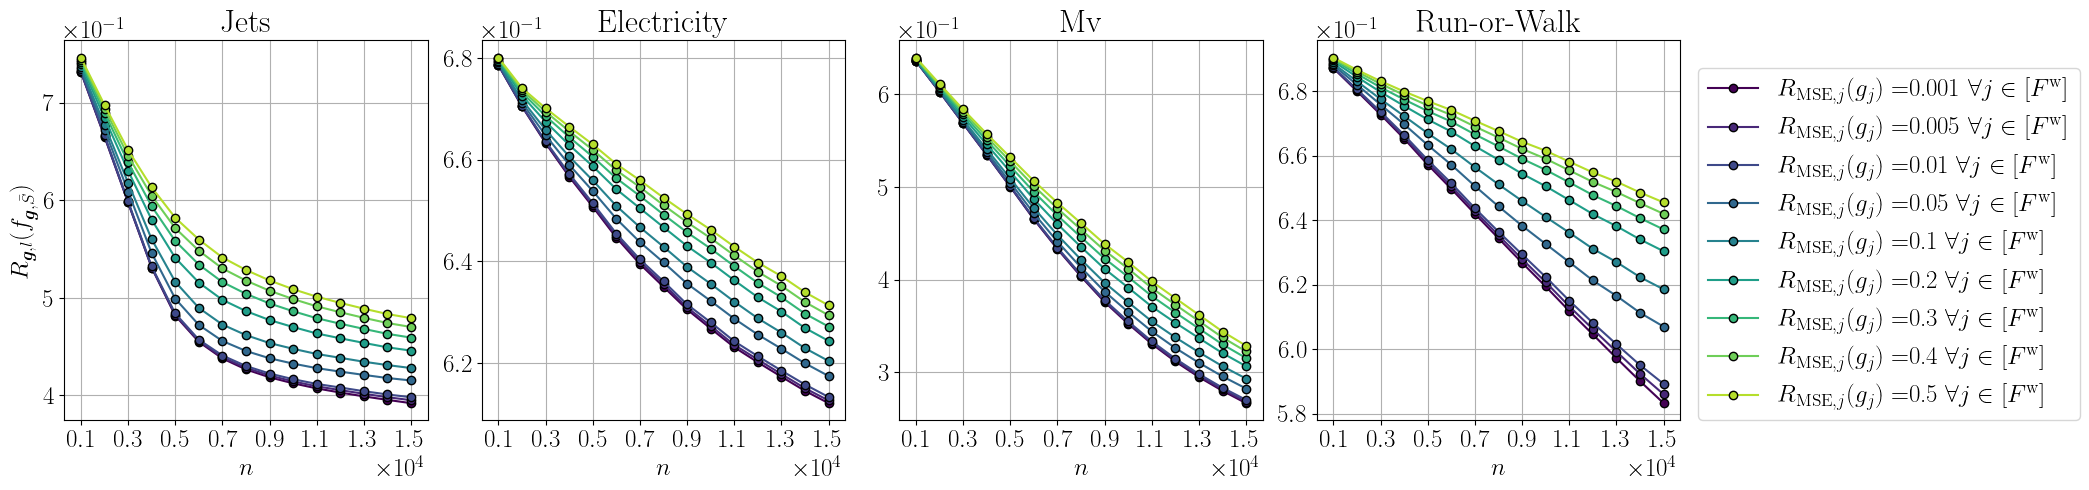

In [11]:
args.exp_name = 'continuous_exp1'
args.miss_pattern = 'MCAR'
args.miss_rate=0.5
args.rm_k=2
   
delta=0.0001
layer_norm=1.0
M_l=2.0
dataset_list = ['jets', 'electricity', 'mv', 'run-or-walk']
seed_list = [42, 43, 44, 45, 46]
use_train_size_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
est_error_mse_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_exp1_multi_data_risk(args=args, 
                        weak_cols_dict=weak_cols_dict,
                        dataset_list = dataset_list,
                        seed_list=seed_list, use_train_size_list=use_train_size_list, 
                        est_error_mse_list=est_error_mse_list,
                        delta=delta, layer_norm=layer_norm, M_l=M_l, best_risk=0.0,
                        each_ax_size=(5,5), fontsize=18,
                        save_name=f'exp1_risk_delta{delta}_lnorm{layer_norm}_Ul{M_l}_mp{args.miss_pattern}_mr{args.miss_rate}',
                        )

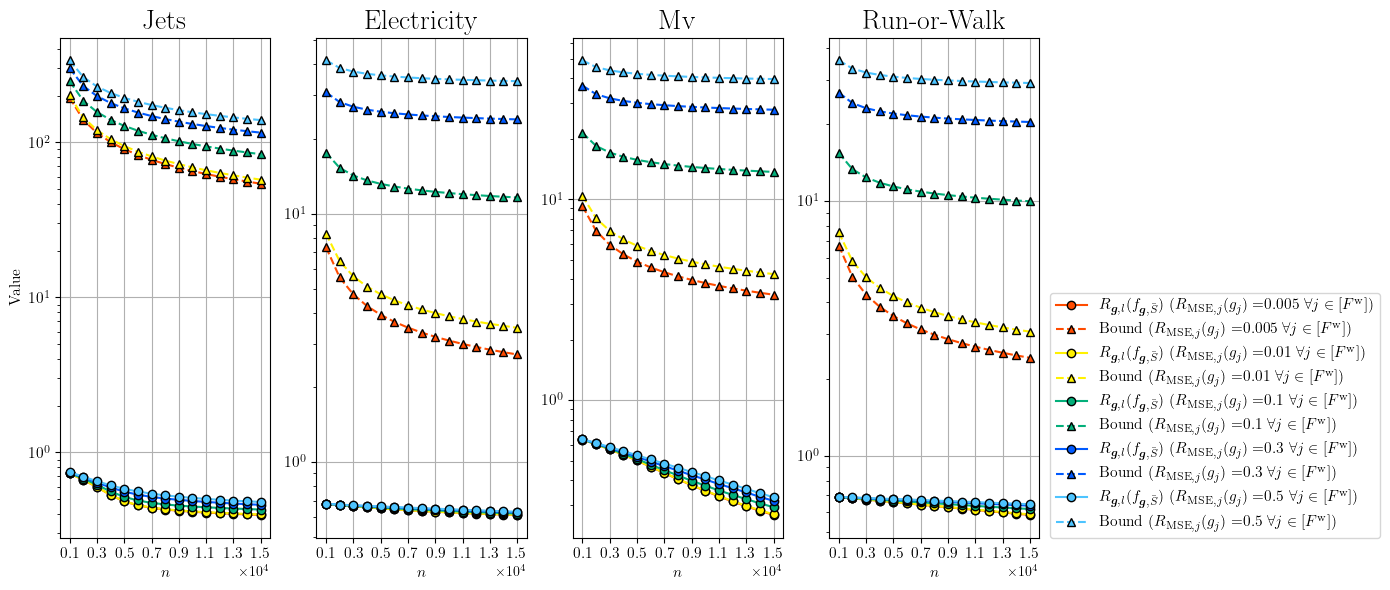

In [12]:
args.exp_name = 'continuous_exp1'
args.miss_pattern = 'MCAR'
args.miss_rate=0.5
args.rm_k=2
   
delta=0.0001
layer_norm=1.0
M_l=2.0
dataset_list = ['jets', 'electricity', 'mv', 'run-or-walk']
seed_list = [42, 43, 44, 45, 46]
use_train_size_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
est_error_mse_list = [0.005, 0.01, 0.1, 0.3, 0.5]
plot_exp1_multi_data2(args=args, 
                     weak_cols_dict=weak_cols_dict,
                        dataset_list = dataset_list,
                        seed_list=seed_list, use_train_size_list=use_train_size_list, 
                        est_error_mse_list=est_error_mse_list,
                        delta=delta, layer_norm=5, M_l=M_l, best_risk=0.0,
                        each_ax_size=(3,6), fontsize=11,
                        save_name=f'exp1_risk_and_bound_same_delta{delta}_lnorm{layer_norm}_Ul{M_l}_mp{args.miss_pattern}_mr{args.miss_rate}')